**Normalizing Flows** (NF)

made by: Anas Aldadi from scratch (uhm using torch and numpy nothing more)

The third generative modelling in this coding tutorials is normalizing flows.

While diffusion models give us the power to generate data when having a noise scheduler, normalizing flow are a set of generative models that unlocks the power generating data by finding the change of random variables.

<img src="https://drive.google.com/uc?id=18C5x9BdKR-J27UWNWCjUQEk1SprE7XdM" width="1000">

this set of generative models have many types:

* Coupling Layers (Affine Coupling and Additive Coupling): These are a key building block in many modern normalizing flows (like Real NVP and Glow). They work by splitting the input dimensions and applying a transformation to one part conditioned on the other part.

* Invertible 1x1 Convolutions: Used in models like Glow, these are linear transformations that are still invertible and help in mixing the channels of the data.

* Continuous Normalizing Flows (CNFs): Instead of a discrete sequence of layers, CNFs define the transformation as a continuous-time differential equation. This leads to different training and evaluation dynamics.

and so much more than those btw!

in this tutorial i'm gonna build a vanilla NF from the original paper, to make the archeticture as clear and simple as possible

**Resources used to make this notebook:**

https://arxiv.org/pdf/1505.05770v6 also see: https://paperswithcode.com/method/normalizing-flows


<img src="https://drive.google.com/uc?id=1JCv39qNSFZvWVoRq4csF_VzxBGzz5tUL" width="1000">

At its core, a normalizing flow aims to transform a simple, known probability distribution (like a standard Gaussian) into a complex, unknown target distribution (often the distribution of your data) through a sequence of invertible and differentiable transformations. [ref](https://paperswithcode.com/method/normalizing-flows)

so inferring from this we will build transformation layers and their inverses!!

A "vanilla" normalizing flow typically refers to a simple flow constructed by stacking one or more basic invertible transformations. The key is that each transformation in the sequence must have a tractable inverse and a tractable determinant of its Jacobian.

~btw i apologize for the bad quality of the image but i couldn't render LaTeX on colab's text cell so i had to screenshot it :(




---


<img src="https://drive.google.com/uc?id=1HypCRb-vYC8xdmG5Ij2lH0brQLWHjDhu" width="1000">

The final output z_k=z is a point in the latent space, which should follow a simple distribution (e.g., a standard Gaussian). During training, the parameters of the transformations are learned such that the distribution of these transformed data points matches the chosen base distribution.



---

<img src="https://drive.google.com/uc?id=1_zn4ePyCw151ahV08hqpmmdtWAhWxbbQ" width="1000">

**In essence:**

* Forward: Maps data to a simple latent space and allows for density estimation.
* Backward: Maps samples from the simple latent space back to the complex data space, enabling generation.

[ref](https://colab.research.google.com/github/whitead/dmol-book/blob/master/dl/flows.ipynb)

good references:
* [Learning distributions on compact support using Normalizing Flows](https://selflein.github.io/normalizing_flow_bounded_domain)
* [On the Universality of Volume-Preserving and Coupling-Based Normalizing Flows](https://arxiv.org/html/2402.06578v2)

        """
                             K                                      K
        --> [Squeeze] -> [FlowStep] -> [Split] -> [Squeeze] -> [FlowStep]
               ^                           v
               |          (L - 1)          |
               + --------------------------+
        """

## Reqs

In [ ]:
import gdown
folder_id = "1ywizLmoqZj_iOA0xFx3y1cJykFlbgkOu"
gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", quiet=False, use_cookies=False)

Retrieving folder contents


Processing file 18C5x9BdKR-J27UWNWCjUQEk1SprE7XdM comparison_GAN_VAE_NF.png
Processing file 1n_PdjTcMVnyoC6pJO3HoTr_uiKzSk2AR important1.png
Processing file 1bUBwJWGdXLR58a18IGRzy0Aok-BbCRl9 important2.png
Processing file 1Sect82BB-UQtG55rsxnDB7nMs15VC-ED important3.png
Processing file 15OR65HGg9zG74v8AywXJ_7OXHXfwVFdF nf.png
Processing file 1-7FoHp4T06MgKy_O3ZLxO-t7Ton3u3J4 simple_flow_161_loss.pth
Processing file 1XVPslA5XkddRwJ8zFcZganlAO0GQJfdR simple_flow.pth


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=18C5x9BdKR-J27UWNWCjUQEk1SprE7XdM
To: /content/normalizing_flow/comparison_GAN_VAE_NF.png
100%|██████████| 255k/255k [00:00<00:00, 18.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n_PdjTcMVnyoC6pJO3HoTr_uiKzSk2AR
To: /content/normalizing_flow/important1.png
100%|██████████| 93.7k/93.7k [00:00<00:00, 7.88MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bUBwJWGdXLR58a18IGRzy0Aok-BbCRl9
To: /content/normalizing_flow/important2.png
100%|██████████| 172k/172k [00:00<00:00, 14.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Sect82BB-UQtG55rsxnDB7nMs15VC-ED
To: /content/normalizing_flow/important3.png
100%|██████████| 163k/163k [00:00<00:00, 16.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=15OR65HGg9zG74v8AywXJ_7OXHXfwVFdF
To: /content/normalizing_flow/nf.png
100%|██████████| 135k/135k [00:

['/content/normalizing_flow/comparison_GAN_VAE_NF.png',
 '/content/normalizing_flow/important1.png',
 '/content/normalizing_flow/important2.png',
 '/content/normalizing_flow/important3.png',
 '/content/normalizing_flow/nf.png',
 '/content/normalizing_flow/simple_flow_161_loss.pth',
 '/content/normalizing_flow/simple_flow.pth']

In [13]:
import torch, torchvision

# torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Torchvision
from torchvision.datasets import MNIST
from torchvision import transforms as T
from torchvision import datasets, transforms

# Others
import glob, re, shutil, os, gc
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm

In [2]:
print(device := torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [ ]:
os.environ['KAGGLEHUB_CACHE'] = '/content/data'

In [3]:
eps = 1e-6

In [239]:
class CelebLoadingData(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.images_paths = sorted(glob.glob(os.path.join(root, '*.jpg')))
        self.transforms= transforms

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx])
        img = img.convert('RGB')
        if self.transforms: img = self.transforms(img)
        # img = img * 255.0 this makes them in range of 0 to 255
        return img

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/celebahq-resized-256x256


In [11]:
root = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'

In [746]:
channels=3; size=64
transformss = T.Compose([
    T.Resize((size, size)),
    T.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
datasett = CelebLoadingData(root, transformss)
len(datasett)

30000

In [692]:
indices = list(range(64))  # first 512 samples
subset_dataset = Subset(datasett, indices)

print(len(subset_dataset))

64


In [583]:
print(num_worker:=os.cpu_count())

12


In [770]:
train_dl = DataLoader(subset_dataset, batch_size=64, num_workers=num_worker, persistent_workers=True, shuffle=True)

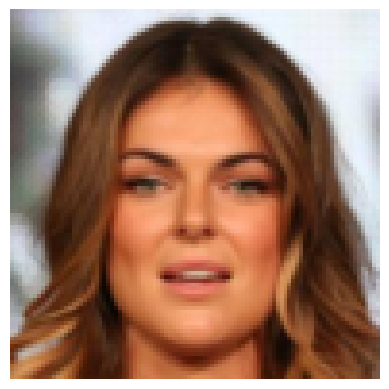

In [437]:
img = next(iter(train_dl))
show(img[0])

In [211]:
torch.max(img)

tensor(255.)

## Helpers

In [17]:
def generate_intermediate_transformations(model, dataloader, device, num_images=4):
    """
    Returns:
        images: Tensor of original images [num_images, 1, 28, 28]
        forward_images: List of tensors at each forward step [step][num_images, 1, 28, 28]
        latent_images: Tensor of sampled latent vectors [num_images, 1, 28, 28]
        backward_images: List of tensors at each backward step [step][num_images, 1, 28, 28]
    """
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            images = batch.to(device)[:num_images]
            batch_size = images.size(0)
            x = images.view(batch_size, -1).float()

            # Forward pass
            forward_images = [x.view(batch_size, 1, 28, 28).cpu()]
            current_z = x
            for transform in model.transforms:
                current_z = transform.inverse(current_z)
                forward_images.append(current_z.view(batch_size, 1, 28, 28).cpu())

            # Latent sample
            # latent_z = torch.randn(batch_size, model.transforms[0].log_scale.shape[0], device=device) # uncomment if you are using logged affine transfromations
            latent_z = torch.randn(batch_size, model.transforms[0].weights.shape[0], device=device) # uncomment this if you are using normal affine transformations
            latent_images = latent_z.view(batch_size, 1, 28, 28).cpu()

            # Backward pass
            backward_images = [latent_images]
            current_x = latent_z
            for transform in reversed(model.transforms):
                current_x = transform(current_x)
                backward_images.append(current_x.view(batch_size, 1, 28, 28).cpu())

            return (
                images.view(batch_size, 1, 28, 28).cpu(),
                forward_images,
                latent_images,
                backward_images
            )

In [18]:
def plot_image_grid(image_list, title_prefix="Step"):
    num_steps = len(image_list)
    num_images = image_list[0].shape[0]
    fig, axes = plt.subplots(num_steps, num_images, figsize=(8, 3 * num_steps))

    if num_images == 1:
        axes = axes[:, np.newaxis]
    elif num_steps == 1:
        axes = axes[np.newaxis, :]

    for i in range(num_steps):
        for j in range(num_images):
            axes[i, j].imshow(image_list[i][j].squeeze(), cmap='gray')
            axes[i, j].axis('off')
        axes[i, 0].set_ylabel(f"{title_prefix} {i}", fontsize=12)

In [19]:
def flush_gpu(device=None, verbose=True):
    if not torch.cuda.is_available():
        if verbose:
            print("CUDA is not available.")
        return

    device = device or torch.cuda.current_device()
    torch.cuda.synchronize(device)

    if verbose:
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"[Before] Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    if verbose:
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"[After]  Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

In [255]:
def preprocess_img(img):
    # img = (img * 0.5 + 0.5).clamp(0, 1) # if you applied normalization to change the range from [0 to 1] to [-1 to 1]
    # img = img.clamp(0, 255).to(torch.uint8)  # if the values of the image are int
    return img.cpu().permute(1,2,0)
def show(img):
    img = preprocess_img(img)
    plt.imshow(img)
    plt.axis('off')

## Data

normal data preperation you can ignore it.

The only important takeaway here is that i discretized MNIST which means the values of the image are in integers not continuous.

In [ ]:
class MNISTSegment(Dataset):

    def __init__(self, root, train=True, transform=None, download=True):
        super().__init__()
        self.dataset = MNIST(
            root=root,
            train=train,
            transform=transform,
            download=download
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = (image * 255).int()
        return image

In [ ]:
print(os.cpu_count())

2


In [299]:
size=28
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    T.Resize((size, size)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dl = DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True, num_workers=2)

In [280]:
for images in train_dl:
    print(images[0].shape)
    break

torch.Size([30000, 3, 28, 28])


In [277]:
flush_gpu()

[Before] Allocated: 4401.83 MB | Reserved: 6318.00 MB
[After]  Allocated: 4401.83 MB | Reserved: 6318.00 MB


In [ ]:
show(images[0])

## Building blocks

In [21]:
size=256

In [22]:
latent_dim = size * size

def log_prob_base(z):
    """
    D-dimentional standard normal distribution where D is latent_dim flattened size of MNIST
    """
    log_p = -.5 * torch.sum(z**2,dim=1) - .5 * latent_dim * np.log(2 * np.pi)
    return log_p

In [23]:
batch_size = 64
dummy_z = torch.randn(batch_size, latent_dim)
log_probs = log_prob_base(dummy_z)
print(f"shape of dummy latent variables: {dummy_z.shape}")
print(f"shape of log probabilities: {log_probs.shape}")
print(f"log probabilities for the first 5 samples:\n{log_probs[:5]}")

shape of dummy latent variables: torch.Size([64, 65536])
shape of log probabilities: torch.Size([64])
log probabilities for the first 5 samples:
tensor([-92881.0469, -92884.2812, -92795.8438, -92974.7188, -92872.6328])


### Invertable transformations

#### ActNorm

Now we define our transformation for the forward and write its inverse!

i chose the simplest ever transformation **"z = W @ x + b"** pretty neat right?! :O

its inverse is not that hard either **"x = (z-b)/W"**

since the chosen transformation is so simple, we'll face a problem during the training which is that the generation will be so bad, and the loss function will start with a very large number even though we are training on MNIST!.

An affine transformation is a mathematical operation that transforms geometric objects while preserving points, straight lines, and planes. It combines linear transformations, such as rotation and scaling, with translations, allowing the manipulation of objects in space without altering their fundamental structure. This transformation is particularly important in computer graphics and image processing, where it is used to manage how images are manipulated and displayed. [ref](https://library.fiveable.me/key-terms/introduction-engineering/affine-transformation)

In [24]:
class ActNorm(nn.Module):
    def __init__(self, num_features, data_format='NCHW'):
        super().__init__()
        self.num_features = num_features
        self.data_format = data_format
        if data_format not in ['NCHW', 'NHWC']:
            raise ValueError(f"Invalid data_format: {data_format}. Must be 'NCHW' or 'NHWC'.")

        # Learnable scale and bias parameters, initialized to None
        self.log_scale = nn.Parameter(torch.zeros(1, num_features, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, num_features, 1, 1))
        self.register_buffer('initialized', torch.tensor(False))

    def forward(self, x, logdet=None):
        if self.training and not self.initialized:
            #initialize the learable params on the first batch
            if self.data_format == 'NCHW':
                mean = torch.mean(x.clone().detach(), dim=[0,2,3], keepdim=True)
                var = torch.var(x.clone().detach(), dim=[0,2,3], keepdim=True)
            else:
                mean = torch.mean(x.clone().detach(), dim=[0,1,3], keepdim=True)
                var = torch.var(x.clone().detach(), dim=[0,1,3], keepdim=True)

            self.log_scale.data.copy_(-.5 * torch.log(var+eps))
            self.bias.data.copy_(-mean * torch.exp(self.log_scale))
            self.initialized.fill_(True)

        scale = torch.exp(self.log_scale)
        y = (x + self.bias) * scale

        if logdet is not None:
            log_det_jacobian = torch.sum(self.log_scale) * torch.prod(torch.tensor(x.shape[2:]))
            logdet = logdet + log_det_jacobian * torch.ones(x.shape[0], device=x.device)
            return y, logdet
        else:
            return y

    def inverse(self, y, logdet=None):
        scale = torch.exp(self.log_scale)
        x = y / scale - self.bias

        if logdet is not None:
            log_det_jacobian = -torch.sum(self.log_scale) * torch.prod(torch.tensor(y.shape[2:]))
            logdet = logdet + log_det_jacobian * torch.ones(y.shape[0], device=y.device)
            return x, logdet
        else:
            return x

    def log_det_jacobian(self, x):
        # For consistency with other layers, although it's computed in forward/inverse
        log_det_j = torch.sum(self.log_scale) * torch.prod(torch.tensor(x.shape[2:]))
        return log_det_j * torch.ones(x.shape[0], device=x.device)

In [25]:
batch_size = 4
channels = 3
height = 8
width = 8
dummy_input = torch.randn(batch_size, channels, height, width)

actnorm = ActNorm(channels)
output = actnorm(dummy_input)

print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)

# During training, the first forward pass will initialize the parameters
actnorm.train()
first_output = actnorm(dummy_input)
print("Initialized log_scale:", actnorm.log_scale.data)
print("Initialized bias:", actnorm.bias.data)

# Subsequent forward passes will use the learned parameters
second_output = actnorm(dummy_input)

# Test the inverse
inverse_output = actnorm.inverse(second_output)
print("Inverse output shape:", inverse_output.shape)
print("Are input and inverse output close?", torch.allclose(dummy_input, inverse_output, rtol=1e-5, atol=1e-8))

Input shape: torch.Size([4, 3, 8, 8])
Output shape: torch.Size([4, 3, 8, 8])
Initialized log_scale: tensor([[[[-0.0519]],

         [[-0.0130]],

         [[ 0.0214]]]])
Initialized bias: tensor([[[[ 0.0291]],

         [[-0.0102]],

         [[-0.0975]]]])
Inverse output shape: torch.Size([4, 3, 8, 8])
Are input and inverse output close? True


#### Invertible1x1Conv

In [26]:
from scipy.linalg import lu_factor, lu_solve

class Invertible1x1Conv(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.num_channels = num_channels
        # initialize a random orthogonal matrix for weights
        W = torch.linalg.qr(torch.randn(num_channels, num_channels))[0]
        self.weights = nn.Parameter(W)

    def forward(self, x, logdet=None):
        batch_size, n_channels, height, width = x.shape #NCHW

        #reshape and apply 1x1 conv
        w = self.weights.view(n_channels, n_channels, 1,1)
        z = F.conv2d(x, w, stride=1, padding=0)

        if logdet is not None:
            #calc the log det of jacobian ldj
            detW = torch.det(self.weights) #torch.det
            ldj = height * width * torch.log(torch.abs(detW)+eps)
            logdet=logdet + ldj * torch.ones(batch_size,device=x.device)
            return z, logdet
        else:
            return z

    def inverse(self, z, logdet=None):
        batch_size, n_channels, height, width = z.shape

        weight_inv = torch.inverse(self.weights) #here torch.inverse
        w_inv = weight_inv.view(n_channels, n_channels, 1,1 )
        x = F.conv2d(z, w_inv, stride=1, padding=0)

        if logdet is not None:
            detW_inv = torch.det(weight_inv) #torch.det
            ldj = height* width * torch.log(torch.abs(detW_inv)+eps)
            logdet = logdet - ldj * torch.ones(batch_size, device=z.device)
            return x, logdet
        else:
            return x

    def log_det_jacobian(self, x):
        batch_size, n_channels, height, width = x.shape
        detW = torch.det(self.weights) #torch.det
        ldj = height * width * torch.log(torch.abs(detW) + eps)
        return ldj * torch.ones(batch_size, device=x.device)

We've used torch.det and torch.inverse directly for simplicity in this initial implementation. In the actual Glow implementation

LU decomposition is used for numerical stability and potentially more efficient inverse computation and determinant calculation, especially for larger channel sizes. Implementing LU decomposition in PyTorch can be a bit more involved, often relying on torch.linalg.lu_factor and torch.linalg.lu_solve or similar functions.

In [27]:
# Let's test the Invertible 1x1 Convolution
batch_size = 4
channels = 3
height = 8
width = 8
dummy_input = torch.randn(batch_size, channels, height, width)

inv_conv = Invertible1x1Conv(channels)
output, logdet = inv_conv(dummy_input, logdet=torch.zeros(batch_size))

print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)
print("Log determinant:", logdet)

# Test the inverse
inverse_output, logdet_inv = inv_conv.inverse(output, logdet=torch.zeros(batch_size))
print("Inverse output shape:", inverse_output.shape)
print("Inverse log determinant:", logdet_inv)
print("Are input and inverse output close?", torch.allclose(dummy_input, inverse_output, rtol=1e-5, atol=1e-8))
print("Is logdet approximately -logdet_inv?", torch.allclose(logdet, -logdet_inv, rtol=1e-5, atol=1e-8))

Input shape: torch.Size([4, 3, 8, 8])
Output shape: torch.Size([4, 3, 8, 8])
Log determinant: tensor([6.1035e-05, 6.1035e-05, 6.1035e-05, 6.1035e-05],
       grad_fn=<AddBackward0>)
Inverse output shape: torch.Size([4, 3, 8, 8])
Inverse log determinant: tensor([-6.1035e-05, -6.1035e-05, -6.1035e-05, -6.1035e-05],
       grad_fn=<SubBackward0>)
Are input and inverse output close? True
Is logdet approximately -logdet_inv? True


#### AffineCoupling

In [28]:
class AffineCoupling(nn.Module):
    def __init__(self, num_channels, mask_type): #although i didn't implemented the mask type mechanism to alternate between modes the current one is channel-wise masking i'll try later to implement spatial masking (aka checkerboard masking)
        super().__init__()
        self.num_channels = num_channels
        if num_channels % 2 == 0:
            self.split_dim = num_channels // 2
        else:
            self.split_dim = num_channels // 2 + 1 # Make the first part slightly larger for odd
        self.transform_dim = num_channels - self.split_dim
        self.mask_type = mask_type

        # nn to predict scale and translation factors
        self.scale_translate_net = nn.Sequential(
            nn.Conv2d(self.split_dim, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 2 * self.transform_dim, kernel_size=3, padding=1), # Output scale and translate
            # nn.Tanh()
        )

        # Initialize the last layer to have small weights for near-identity transform initially
        nn.init.zeros_(self.scale_translate_net[-1].weight)
        nn.init.zeros_(self.scale_translate_net[-1].bias)
        # self.scale_translate_net[-2].weight.data.mul_(0.1)
        # self.scale_translate_net[-2].bias.data.mul_(0.)

    def forward(self, x, logdet=None):
        split_sizes = [self.split_dim, self.transform_dim]
        x_a, x_b = torch.split(x, split_sizes, dim=1)

        st = self.scale_translate_net(x_a)
        scale, translate = torch.split(st, self.transform_dim, dim=1)
        scale = torch.sigmoid(scale + 2) # Ensure scale is positive

        y_a = x_a
        y_b = scale * x_b + translate

        if (logdet is not None):
            log_det_jacobian = torch.sum(torch.log(scale.abs() + 1e-6), dim=[1, 2, 3])
            logdet = logdet + log_det_jacobian
            return torch.cat([y_a, y_b], dim=1), logdet
        else:
            return torch.cat([y_a, y_b], dim=1)

    def inverse(self, y, logdet=None):
        split_sizes = [self.split_dim, self.transform_dim]
        y_a, y_b = torch.split(y, split_sizes, dim=1)

        st = self.scale_translate_net(y_a)
        scale, translate = torch.split(st, self.transform_dim, dim=1)
        scale = torch.sigmoid(scale + 2)

        x_a = y_a
        x_b = (y_b - translate) / (scale + 1e-6)

        if logdet is not None:
            log_det_jacobian = -torch.sum(torch.log(scale.abs() + 1e-6), dim=[1, 2, 3])
            logdet = logdet + log_det_jacobian
            return torch.cat([x_a, x_b], dim=1), logdet
        else:
            return torch.cat([x_a, x_b], dim=1)

    def log_det_jacobian(self, x):
        split_sizes = [self.split_dim, self.transform_dim]
        x_a, _ = torch.split(x, split_sizes, dim=1)
        st = self.scale_translate_net(x_a)
        scale, _ = torch.split(st, self.transform_dim, dim=1)
        scale = torch.sigmoid(scale + 2)
        log_det_j = torch.sum(torch.log(scale.abs() + 1e-6), dim=[1, 2, 3])
        return log_det_j

In [29]:
# Let's test the Affine Coupling Layer
batch_size = 4
channels = 3
height = 8
width = 8
dummy_input = torch.randn(batch_size, channels, height, width)

coupling_layer = AffineCoupling(channels, mask_type='channel')
output, logdet = coupling_layer(dummy_input, logdet=torch.zeros(batch_size))

print("\n--- Testing Affine Coupling Layer ---")
print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)
print("Log determinant:", logdet)

# Test the inverse
inverse_output, logdet_inv = coupling_layer.inverse(output, logdet=torch.zeros(batch_size))
print("Inverse output shape:", inverse_output.shape)
print("Inverse log determinant:", logdet_inv)
print("Are input and inverse output close?", torch.allclose(dummy_input, inverse_output, rtol=1e-5, atol=1e-8))
print("Is logdet approximately -logdet_inv?", torch.allclose(logdet, -logdet_inv, rtol=1e-5, atol=1e-8))



--- Testing Affine Coupling Layer ---
Input shape: torch.Size([4, 3, 8, 8])
Output shape: torch.Size([4, 3, 8, 8])
Log determinant: tensor([-8.1233, -8.1233, -8.1233, -8.1233], grad_fn=<AddBackward0>)
Inverse output shape: torch.Size([4, 3, 8, 8])
Inverse log determinant: tensor([8.1233, 8.1233, 8.1233, 8.1233], grad_fn=<AddBackward0>)
Are input and inverse output close? True
Is logdet approximately -logdet_inv? True


#### GlowBlock

In [30]:
class GlowBlock(nn.Module):
    def __init__(self, num_channels, mask_type):
        super().__init__()
        self.num_channels = num_channels
        self.mask_type = mask_type
        self.actnorm = ActNorm(num_channels)
        self.inv_conv = Invertible1x1Conv(num_channels)
        self.affine_coupling = AffineCoupling(num_channels, mask_type)

    def forward(self, x, logdet=None):
        x, logdet = self.actnorm(x, logdet)
        x, logdet = self.inv_conv(x, logdet)
        x, logdet = self.affine_coupling(x, logdet)
        return x, logdet

    def inverse(self, z, logdet=None):
        z, logdet = self.affine_coupling.inverse(z, logdet)
        z, logdet = self.inv_conv.inverse(z, logdet)
        z, logdet = self.actnorm.inverse(z, logdet)
        return z, logdet

In [31]:
# Let's test the GlowBlock
batch_size = 4
channels = 3
height = 8
width = 8
dummy_input = torch.randn(batch_size, channels, height, width)

glow_block = GlowBlock(channels, mask_type='channel')
output, logdet = glow_block(dummy_input, logdet=torch.zeros(batch_size))

print("\n--- Testing GlowBlock ---")
print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)
print("Log determinant:", logdet)

# Test the inverse
inverse_output, logdet_inv = glow_block.inverse(output, logdet=torch.zeros(batch_size))
print("Inverse output shape:", inverse_output.shape)
print("Inverse log determinant:", logdet_inv)
print("Are input and inverse output close?", torch.allclose(dummy_input, inverse_output, rtol=1e-5, atol=1e-3))
print("Is logdet approximately -logdet_inv?", torch.allclose(logdet, -logdet_inv, rtol=1e-5, atol=1e-3))


--- Testing GlowBlock ---
Input shape: torch.Size([4, 3, 8, 8])
Output shape: torch.Size([4, 3, 8, 8])
Log determinant: tensor([-14.9573, -14.9573, -14.9573, -14.9573], grad_fn=<AddBackward0>)
Inverse output shape: torch.Size([4, 3, 8, 8])
Inverse log determinant: tensor([14.9573, 14.9573, 14.9573, 14.9573], grad_fn=<AddBackward0>)
Are input and inverse output close? True
Is logdet approximately -logdet_inv? True


In [527]:
class Squeeze(nn.Module):
    def __init__(self, factor=2):
        super().__init__()
        self.factor = factor

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        if height % self.factor != 0 or width % self.factor != 0:
            print(f'height {height}, width {width}')
            raise ValueError("Height and width must be divisible by the factor.")
        new_height = height // self.factor
        new_width = width // self.factor
        new_channels = channels * (self.factor ** 2)
        # Interleave spatial dims into channel dim
        y = x.view(batch_size, channels, new_height, self.factor, new_width, self.factor)
        y = y.permute(0, 1, 3, 5, 2, 4).contiguous()
        y = y.view(batch_size, new_channels, new_height, new_width)
        return y

class Unsqueeze(nn.Module):
    def __init__(self, factor=2):
        super().__init__()
        self.factor = factor

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        if channels % (self.factor ** 2) != 0:
            print(f'channels {channels}')
            raise ValueError("Channels must be divisible by (factor ** 2).")
        new_channels = channels // (self.factor ** 2)
        new_height = height * self.factor
        new_width = width * self.factor
        # Inverse of the squeeze operation
        y = x.view(batch_size, new_channels, self.factor, self.factor, height, width)
        y = y.permute(0, 1, 4, 2, 5, 3).contiguous()
        y = y.view(batch_size, new_channels, new_height, new_width)
        return y

In [33]:
batch_size = 4
channels = 3
height = 8
width = 8
factor = 2
dummy_input = torch.randn(batch_size, channels, height, width)

squeeze = Squeeze(factor)
squeezed_output = squeeze(dummy_input)
print("\n--- Testing Squeeze ---")
print("Input shape:", dummy_input.shape)
print("Squeezed output shape:", squeezed_output.shape)

unsqueeze = Unsqueeze(factor)
unsqueezed_output = unsqueeze(squeezed_output)
print("\n--- Testing Unsqueeze ---")
print("Unsqueezed output shape:", unsqueezed_output.shape)
print("Are input and unsqueezed output close?", torch.allclose(dummy_input, unsqueezed_output, rtol=1e-5, atol=1e-8))

# Test with a different factor
factor = 4
dummy_input_large = torch.randn(batch_size, channels, 16, 16)
squeeze_large = Squeeze(factor)
squeezed_output_large = squeeze_large(dummy_input_large)
print("\n--- Testing Squeeze with factor 4 ---")
print("Input shape:", dummy_input_large.shape)
print("Squeezed output shape:", squeezed_output_large.shape)

unsqueeze_large = Unsqueeze(factor)
unsqueezed_output_large = unsqueeze_large(squeezed_output_large)
print("\n--- Testing Unsqueeze with factor 4 ---")
print("Unsqueezed output shape:", unsqueezed_output_large.shape)
print("Are input and unsqueezed output close?", torch.allclose(dummy_input_large, unsqueezed_output_large, rtol=1e-5, atol=1e-8))


--- Testing Squeeze ---
Input shape: torch.Size([4, 3, 8, 8])
Squeezed output shape: torch.Size([4, 12, 4, 4])

--- Testing Unsqueeze ---
Unsqueezed output shape: torch.Size([4, 3, 8, 8])
Are input and unsqueezed output close? True

--- Testing Squeeze with factor 4 ---
Input shape: torch.Size([4, 3, 16, 16])
Squeezed output shape: torch.Size([4, 48, 4, 4])

--- Testing Unsqueeze with factor 4 ---
Unsqueezed output shape: torch.Size([4, 3, 16, 16])
Are input and unsqueezed output close? True


In [34]:
class Split(nn.Module):
    def __init__(self, num_channels, split_factor=2):
        super().__init__()
        if num_channels % split_factor != 0:
            raise ValueError(f"Number of channels ({num_channels}) must be divisible by the split factor ({split_factor}).")
        self.split_factor = split_factor
        self.out_channels = num_channels // split_factor

    def forward(self, x, logdet=None):
        z1 = x[:, :self.out_channels, :, :]
        z2 = x[:, self.out_channels:, :, :]
        if logdet is not None:
            return (z1, z2), logdet
        else:
            return (z1, z2)

class Unsplit(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.out_channels = out_channels

    def forward(self, z1, z2, logdet=None):
        x = torch.cat([z1, z2], dim=1)
        if logdet is not None:
            return x, logdet
        else:
            return x

In [35]:
batch_size = 4
in_channels = 12
height = 8
width = 8
split_factor = 2

# Create a dummy input tensor
dummy_input = torch.randn(batch_size, in_channels, height, width)

# Instantiate Split and perform forward pass
split_layer = Split(in_channels, split_factor)
z1, z2 = split_layer(dummy_input)

print("--- Testing Isolated Split ---")
print("Input shape:", dummy_input.shape)
print("z1 shape:", z1.shape)
print("z2 shape:", z2.shape)

# Instantiate Unsplit and perform forward pass
unsplit_layer = Unsplit(in_channels)
reconstructed_x = unsplit_layer(z1, z2)

print("\n--- Testing Isolated Unsplit ---")
print("Reconstructed x shape:", reconstructed_x.shape)
print("Are input and reconstructed x close?", torch.allclose(dummy_input, reconstructed_x, rtol=1e-5, atol=1e-8))

# Test with odd number of initial channels (should raise ValueError in Split)
try:
    split_odd = Split(7)
except ValueError as e:
    print(f"\n--- Testing Split with odd channels ---")
    print(f"Caught expected error: {e}")

# Test Unsplit with mismatched input sizes
mismatched_z2 = torch.randn(batch_size, z2.shape[1] + 1, height, width)
try:
    unsplit_mismatch = Unsplit(in_channels + 1) # Initialize with the expected output channels
    reconstructed_mismatch = unsplit_mismatch(z1, mismatched_z2)
except RuntimeError as e:
    print(f"\n--- Testing Unsplit with mismatched sizes ---")
    print(f"Caught expected error: {e}")


--- Testing Isolated Split ---
Input shape: torch.Size([4, 12, 8, 8])
z1 shape: torch.Size([4, 6, 8, 8])
z2 shape: torch.Size([4, 6, 8, 8])

--- Testing Isolated Unsplit ---
Reconstructed x shape: torch.Size([4, 12, 8, 8])
Are input and reconstructed x close? True

--- Testing Split with odd channels ---
Caught expected error: Number of channels (7) must be divisible by the split factor (2).


## The glow model ^-^

In [212]:
class GlowModel(nn.Module):
    def __init__(self, num_channels, image_size, num_blocks, num_levels, factor=2):
        super().__init__()
        self.num_channels = num_channels
        self.image_size = image_size
        self.num_blocks = num_blocks
        self.num_levels = num_levels
        self.factor = factor

        self.layers = nn.ModuleList()
        current_channels = num_channels
        current_size = image_size

        for level in range(num_levels):
            for _ in range(num_blocks):
                self.layers.append(GlowBlock(current_channels, mask_type='channel'))
            if level < num_levels - 1:
                self.layers.append(Squeeze(factor))
                current_channels *= (factor ** 2)
                current_size //= factor
                self.layers.append(Split(current_channels))
                current_channels //= 2 # After split, the remaining part has half the channels

        self.n_latent_variables = self.calculate_latent_size(num_channels, image_size, num_levels, factor)

    def calculate_latent_size(self, initial_channels, initial_size, num_levels, factor):
        channels = initial_channels
        size = initial_size
        latent_size = 0
        for level in range(num_levels):
            if level < num_levels - 1:
                channels *= (factor ** 2)
                size //= factor
                latent_size += (channels // 2) * (size ** 2)
                channels //= 2
            else:
                latent_size += channels * (size ** 2)
        return latent_size

    def forward(self, x, logdet=None):
        all_z = []
        current_x = x
        current_logdet = logdet

        for layer in self.layers:
            if isinstance(layer, GlowBlock):
                current_x, current_logdet = layer(current_x, current_logdet)
            elif isinstance(layer, Squeeze):
                current_x = layer(current_x)
            elif isinstance(layer, Split):
                split_output = layer(current_x, current_logdet)
                if logdet is not None:
                    current_x, z = split_output[0]
                    current_logdet = split_output[1]
                else:
                    current_x, z = split_output
                all_z.append(z)

        all_z.append(current_x) # The final remaining part is also latent
        return all_z, current_logdet

    def inverse(self, z_list, logdet=None):
        current_x = z_list[-1]
        current_logdet = logdet
        # print("Inverse Initial z Shape:", current_x.shape)

        reversed_layers = list(reversed(self.layers))
        z_index = len(z_list) - 2 # Start from the second to last z

        for layer in reversed_layers:
            # print("Inverse Layer:", layer.__class__.__name__, "Input Shape:", current_x.shape)
            if isinstance(layer, GlowBlock):
                current_x, current_logdet = layer.inverse(current_x, current_logdet)
            elif isinstance(layer, Squeeze):
                current_x = Unsqueeze(self.factor)(current_x)
            elif isinstance(layer, Split):
                z = z_list[z_index]
                # print(f"Accessing z (index {z_index}) shape:", z.shape)
                out_channels = current_x.shape[1] + z.shape[1]
                current_x = Unsplit(out_channels)(current_x, z)
                z_index -= 1

        return current_x, current_logdet


In [468]:
# Example instantiation:
num_channels = 3  # For RGB images
image_size = size    # Example image size
num_blocks = 1     # Number of GlowBlocks per level
num_levels = 10     # Number of multi-scale levels
factor = 2       # Squeeze factor

glow_model = GlowModel(num_channels, image_size, num_blocks, num_levels, factor)
print(glow_model)

GlowModel(
  (layers): ModuleList(
    (0): GlowBlock(
      (actnorm): ActNorm()
      (inv_conv): Invertible1x1Conv()
      (affine_coupling): AffineCoupling(
        (scale_translate_net): Sequential(
          (0): Conv2d(2, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(512, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (1): Squeeze()
    (2): Split()
    (3): GlowBlock(
      (actnorm): ActNorm()
      (inv_conv): Invertible1x1Conv()
      (affine_coupling): AffineCoupling(
        (scale_translate_net): Sequential(
          (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(512, 6, kernel_size=(3, 3), stride=(1, 1), paddi

In [401]:
all_params = sum(p.numel() for p in glow_model.parameters())
print(f"Total parameters (trainable + non-trainable): {all_params:,}")

Total parameters (trainable + non-trainable): 37,336,377


In [372]:
# Example forward pass:
batch_size = 4
dummy_input = torch.randn(batch_size, num_channels, image_size, image_size)
z_list, logdet = glow_model(dummy_input, logdet=torch.zeros(batch_size))
print("\nLatent z list shapes:", [z.shape for z in z_list])
print("Log determinant:", logdet.shape)

# Example inverse pass:
dummy_z_list = [torch.randn_like(z) for z in z_list]
reconstructed_x, logdet_inv = glow_model.inverse(dummy_z_list, logdet=torch.zeros(batch_size))
print("\nReconstructed x shape:", reconstructed_x.shape)
print("Inverse log determinant:", logdet_inv.shape)


Latent z list shapes: [torch.Size([4, 6, 64, 64]), torch.Size([4, 12, 32, 32]), torch.Size([4, 24, 16, 16]), torch.Size([4, 48, 8, 8]), torch.Size([4, 48, 8, 8])]
Log determinant: torch.Size([4])

Reconstructed x shape: torch.Size([4, 3, 128, 128])
Inverse log determinant: torch.Size([4])


In [504]:
img[0].unsqueeze(dim=0).shape

torch.Size([1, 3, 96, 96])

In [448]:
single_img =img[0].unsqueeze(dim=0).to('cpu')

In [375]:
single_img.device

device(type='cpu')

In [376]:
glow_model =glow_model.to('cpu')

In [377]:
# img
z_list, logdet = glow_model(single_img, logdet=torch.zeros(batch_size))
reconstructed_x, logdet_inv = glow_model.inverse(z_list, logdet=torch.zeros(batch_size))

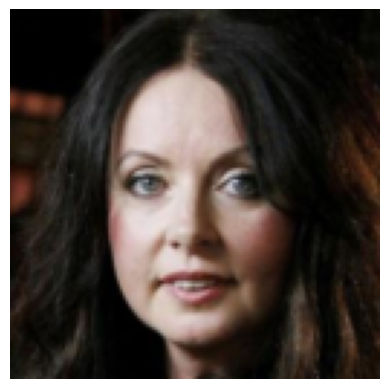

In [378]:
show(reconstructed_x[0].detach())

In [493]:
flush_gpu()

[Before] Allocated: 7552.87 MB | Reserved: 20712.00 MB
[After]  Allocated: 3549.67 MB | Reserved: 7046.00 MB


## Model

should be VanillaFlow the naming here is just for fun

In [ ]:
#testing the forward pass
batch_size = 64
dummy_x = torch.randn(batch_size, latent_dim)
latent_z, log_det_j_forward = simple_flow(dummy_x.to(device))

print(f"shape of input data (x): {dummy_x.shape}")
print(f"shape of latent variable (z): {latent_z.shape}")
print(f"shape of log determinant of jacobian (forward): {log_det_j_forward.shape}")

#testing the backward pass (sampling)
dummy_z_sample = torch.randn(batch_size, latent_dim) # sample from the base distribution
generated_x = simple_flow.backward(dummy_z_sample.to(device))
print(f"shape of generated data (x): {generated_x.shape}")

shape of input data (x): torch.Size([64, 784])
shape of latent variable (z): torch.Size([64, 784])
shape of log determinant of jacobian (forward): torch.Size([64])
shape of generated data (x): torch.Size([64, 784])


In [ ]:
import torch

# Example input image
batch_size = 4
num_channels = 3
image_size = 32
dummy_input = torch.randn(batch_size, num_channels, image_size, image_size)
initial_logdet = torch.zeros(batch_size)

# Forward pass: Encode the input image into latent variables
with torch.no_grad():
    z_list, logdet = glow_model(dummy_input, initial_logdet)

print("\n--- Encoding (Forward Pass) ---")
print("Input image shape:", dummy_input.shape)
print("List of latent variable shapes:", [z.shape for z in z_list])
print("Log determinant:", logdet)

# Inverse pass: Decode the latent variables back to an image
with torch.no_grad():
    reconstructed_x, reconstructed_logdet = glow_model.inverse(z_list, torch.zeros(batch_size))

print("\n--- Decoding (Inverse Pass) ---")
print("Reconstructed image shape:", reconstructed_x.shape)
print("Reconstructed log determinant:", reconstructed_logdet)

# Check if the reconstructed image is close to the original input
are_close = torch.allclose(dummy_input, reconstructed_x, rtol=1e-5, atol=1e-4)
print("\nAre the original and reconstructed images close?", are_close)

# Check if the log determinant of the forward and inverse are approximately opposite
is_logdet_opposite = torch.allclose(logdet, -reconstructed_logdet, rtol=1e-5, atol=1e-8)
print("Is log determinant approximately opposite?", is_logdet_opposite)


--- Encoding (Forward Pass) ---
Input image shape: torch.Size([4, 3, 32, 32])
List of latent variable shapes: [torch.Size([4, 6, 16, 16]), torch.Size([4, 12, 8, 8]), torch.Size([4, 12, 8, 8])]
Log determinant: tensor([-255.3314, -255.3314, -255.3314, -255.3314])
Inverse Initial z Shape: torch.Size([4, 12, 8, 8])
Inverse Layer: GlowBlock Input Shape: torch.Size([4, 12, 8, 8])
Inverse Layer: GlowBlock Input Shape: torch.Size([4, 12, 8, 8])
Inverse Layer: Split Input Shape: torch.Size([4, 12, 8, 8])
Accessing z (index 1) shape: torch.Size([4, 12, 8, 8])
Inverse Layer: Squeeze Input Shape: torch.Size([4, 24, 8, 8])
Inverse Layer: GlowBlock Input Shape: torch.Size([4, 6, 16, 16])
Inverse Layer: GlowBlock Input Shape: torch.Size([4, 6, 16, 16])
Inverse Layer: Split Input Shape: torch.Size([4, 6, 16, 16])
Accessing z (index 0) shape: torch.Size([4, 6, 16, 16])
Inverse Layer: Squeeze Input Shape: torch.Size([4, 12, 16, 16])
Inverse Layer: GlowBlock Input Shape: torch.Size([4, 3, 32, 32])
Inve

In [ ]:
img = next(iter(train_dl))

In [ ]:
img.shape

torch.Size([30000, 1, 28, 28])

In [ ]:
# reshape flat vector to image shape (batch, channels, height, width)
generated_x_image = generated_x.view(batch_size, 1, 28, 28)
dummy_x_image = dummy_x.view(batch_size, 1, 28, 28)

In [ ]:
reconstructed_img.shape

torch.Size([1, 1, 28, 28])

identical reconstructed images means the model is working as intended! it forward and backwarded perfectly.

In [ ]:
reconstructed_x.shape

torch.Size([4, 3, 32, 32])

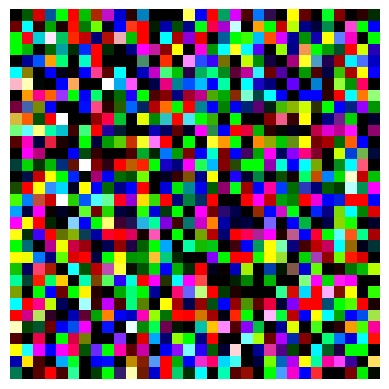

In [ ]:
show(reconstructed_x[0])

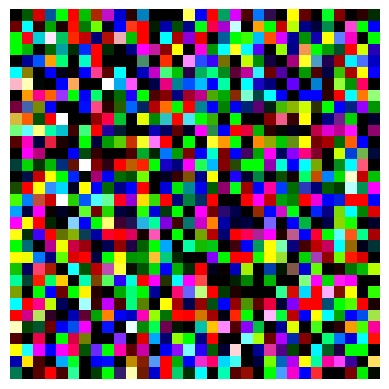

In [ ]:
show(dummy_input[0])

poor generation as you can see. don't get frustrated cuz its gonna persists being bad even after training lol

as i stated before this is stemming from the simplicity of the transformation

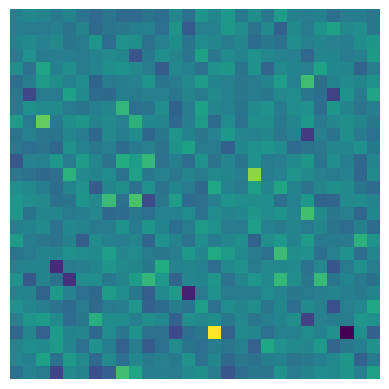

In [ ]:
show(generated_x_image[0].detach())

## Training!

Try loading celeba and also change to print every 10 steps and break after 50

In [402]:
def loss_function(z_list, logdet):
    loss = 0
    for z in z_list:
        loss += torch.sum(z ** 2) / 2
    loss -= torch.sum(logdet)
    return loss / z_list[0].shape[0] # Normalize by batch size

def train_step(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    x = data
    x = x.to(device)
    logdet = torch.zeros(x.shape[0], device=device)
    z_list, logdet = model(x, logdet)
    loss = loss_function(z_list, logdet)
    loss.backward()
    optimizer.step()
    return loss.item()

In [494]:
size

64

In [250]:
for i in glow_model.parameters():
    print(i.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [775]:
num_channels = 3  # For RGB images
image_size = size    # Example image size
num_blocks = 2     # Number of GlowBlocks per level
num_levels = 2    # Number of multi-scale levels
factor = 2       # Squeeze factor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
glow_model = GlowModel(num_channels, image_size, num_blocks, num_levels, factor).to(device)
optimizer = optim.Adam(glow_model.parameters(), lr=1e-3)

In [776]:
all_params = sum(p.numel() for p in glow_model.parameters())
print(f"Total parameters (trainable + non-trainable): {all_params:,}")

Total parameters (trainable + non-trainable): 9,561,230


In [711]:
glow_model = glow_model.to('cpu')

In [703]:
img = next(iter(train_dl))
single_img = img[0].unsqueeze(dim=0).to('cpu')
single_img.shape

torch.Size([1, 3, 128, 128])

In [555]:
print(glow_model)

GlowModel(
  (layers): ModuleList(
    (0): GlowBlock(
      (actnorm): ActNorm()
      (inv_conv): Invertible1x1Conv()
      (affine_coupling): AffineCoupling(
        (scale_translate_net): Sequential(
          (0): Conv2d(2, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(512, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
  )
)


In [556]:
3072%2

0

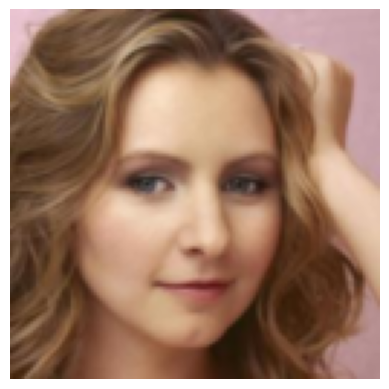

In [712]:
z_list, _ = glow_model(single_img, logdet=torch.zeros(1))
recon, _ = glow_model.inverse(z_list, logdet=torch.zeros(1))
show(recon[0].detach())

In [612]:
counter=10

In [95]:
shutil.rmtree('/content/flow_training')

In [713]:
glow_model = glow_model.to('cuda')

In [706]:
gen_im=[]

In [778]:
# Number of training epochs
num_epochs = 25
gen_im=[]
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, data in enumerate(train_dl):
        loss = train_step(glow_model, data, optimizer)
        epoch_loss += loss
        # if (i + 1) % 1 == 0:
        if (counter+1) % 1 == 0:
            generated_images = sample_from_prior(glow_model)
            gen_im.append(generated_images)
            # plot_and_save_images(generated_images, folder="flow_training", prefix=f"glow_output_{counter}", saving=False)
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dl)}], Loss: {loss:.4f}")
            counter+=1
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss / len(train_dl):.4f}")

print("Training finished!")

# You can now save the trained model:
# torch.save(glow_model.state_dict(), 'glow_mnist.pth')

Epoch [1/25], Step [1/1], Loss: -25889.6211
Epoch [1/25], Average Loss: -25889.6211
Epoch [2/25], Step [1/1], Loss: -30047.4375
Epoch [2/25], Average Loss: -30047.4375
Epoch [3/25], Step [1/1], Loss: 29705.3594
Epoch [3/25], Average Loss: 29705.3594
Epoch [4/25], Step [1/1], Loss: -43889.6484
Epoch [4/25], Average Loss: -43889.6484
Epoch [5/25], Step [1/1], Loss: -30412.4570
Epoch [5/25], Average Loss: -30412.4570
Epoch [6/25], Step [1/1], Loss: -30872.6328
Epoch [6/25], Average Loss: -30872.6328
Epoch [7/25], Step [1/1], Loss: -46003.1602
Epoch [7/25], Average Loss: -46003.1602
Epoch [8/25], Step [1/1], Loss: -58848.6797
Epoch [8/25], Average Loss: -58848.6797
Epoch [9/25], Step [1/1], Loss: -64970.5977
Epoch [9/25], Average Loss: -64970.5977
Epoch [10/25], Step [1/1], Loss: -66628.0859
Epoch [10/25], Average Loss: -66628.0859
Epoch [11/25], Step [1/1], Loss: -67007.5000
Epoch [11/25], Average Loss: -67007.5000
Epoch [12/25], Step [1/1], Loss: -66922.9531
Epoch [12/25], Average Loss: 

In [761]:
del glow_model

In [659]:
import time

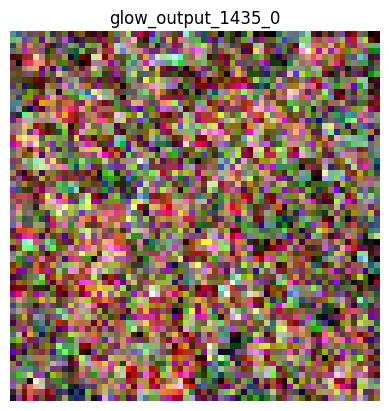

In [779]:
for i in gen_im:
    plot_and_save_images(i, folder="flow_training", prefix=f"glow_output_{counter}", saving=False)
    time.sleep(.09)

156127.4531

In [777]:
flush_gpu(verbose=False)

In [382]:
import torch
import torchvision.utils as vutils

# Assume glow_model is already defined, trained, and on the correct device


def latent_generation(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    # Example of generating images:
    batch_size = 2
    num_channels = 3  # Or 1 for MNIST, adjust based on your model
    image_size = size  # Or 28 for MNIST, adjust based on your model

    z_list = []
    current_size = image_size
    current_channels = num_channels

    for layer in model.layers:
        if isinstance(layer, Squeeze):
            current_size //= layer.factor
            current_channels *= (layer.factor ** 2)
        elif isinstance(layer, Split):
            split_channels = current_channels // 2
            z_list.append(torch.randn(batch_size, split_channels, current_size, current_size, device=device))
            current_channels -= split_channels

    # The final remaining part
    z_list.append(torch.randn(batch_size, current_channels, current_size, current_size, device=device))

    # print("\n--- Generating Latent Variables ---")
    # print("Generated z list shapes:", [z.shape for z in z_list])

    # Inverse pass: Decode the latent variables to generate images
    with torch.no_grad():
        generated_images, _ = model.inverse(z_list, logdet=torch.zeros(batch_size, device=device))
    return generated_images
    # print("\n--- Image Generation (Inverse Pass) ---")
    # print("Generated images shape:", generated_images.shape)


In [576]:
def sample_from_prior(model, batch_size=1):
    device = next(model.parameters()).device
    dummy = torch.randn(batch_size, model.num_channels, model.image_size, model.image_size).to(device)

    with torch.no_grad():
        z_list, _ = model(dummy, logdet=torch.zeros(batch_size, device=device))  # shape probe
        z_sampled = [torch.randn_like(z) for z in z_list]  # correct shapes!
        generated, _ = model.inverse(z_sampled, logdet=torch.zeros(batch_size, device=device))
        return generated

In [577]:
generated_images = sample_from_prior(glow_model)

In [333]:
generated_images.shape

torch.Size([64, 3, 64, 64])

In [334]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from IPython.display import clear_output

def plot_and_save_images(images, folder="flow_training", prefix="generated", clear=True, saving=True):
    if clear:
        clear_output(wait=True)  # Clear previous plot/output in notebook

    os.makedirs(folder, exist_ok=True)

    if images.ndim == 4:  # Batch
        for i, img_tensor in enumerate(images):
            img = TF.to_pil_image(img_tensor.cpu().clamp(0, 1))

            if saving: img.save(os.path.join(folder, f"{prefix}_{i}.png"))
            plt.figure()
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{prefix}_{i}")
            plt.show()
    elif images.ndim == 3:  # Single image
        images = preprocess_img(images)
        img = TF.to_pil_image(images.cpu().clamp(0, 1))
        if saving: img.save(os.path.join(folder, f"{prefix}.png"))
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.title(prefix)
        plt.show()


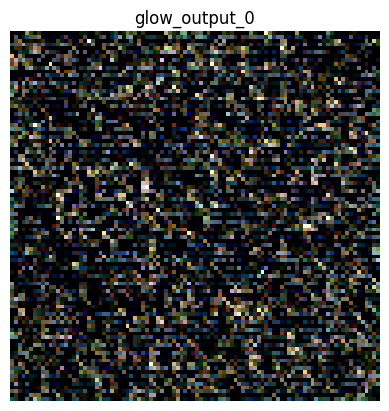

In [462]:
plot_and_save_images(generated_images, folder="flow_training", prefix="glow_output")

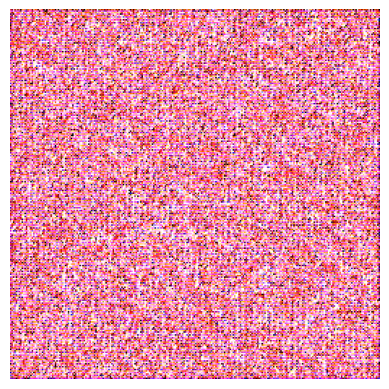

In [56]:
show(generated_images[0])

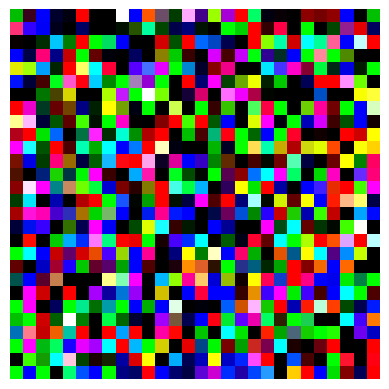

In [ ]:
show(generated_images[2])

### Saving and loading here

saving

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
model_path = "/content/normalizing_flow/simple_flow_experimental.pth"
torch.save({
    'model_state_dict': simple_flow.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, model_path)

loading

In [ ]:
model = VanillaChocolateFlow(num_layers=2, input_dim=28*28).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
checkpoint = torch.load("/content/normalizing_flow/simple_flow_161_loss.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])

## Inference and seeing the generation through the layers

In [ ]:
# generate images
original_images, forward_steps, latent_images, backward_steps = generate_intermediate_transformations(
    model=model,
    dataloader=train_dl,
    device=device,
    num_images=2
)

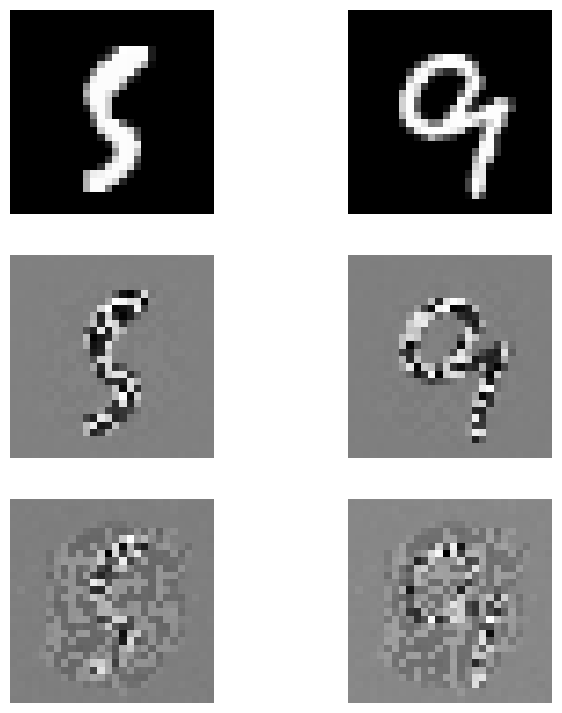

In [ ]:
plot_image_grid(forward_steps, title_prefix="forward")

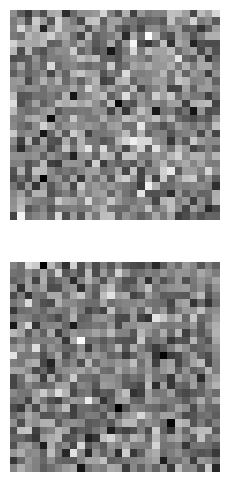

In [ ]:
plot_image_grid(latent_images, title_prefix="latent")

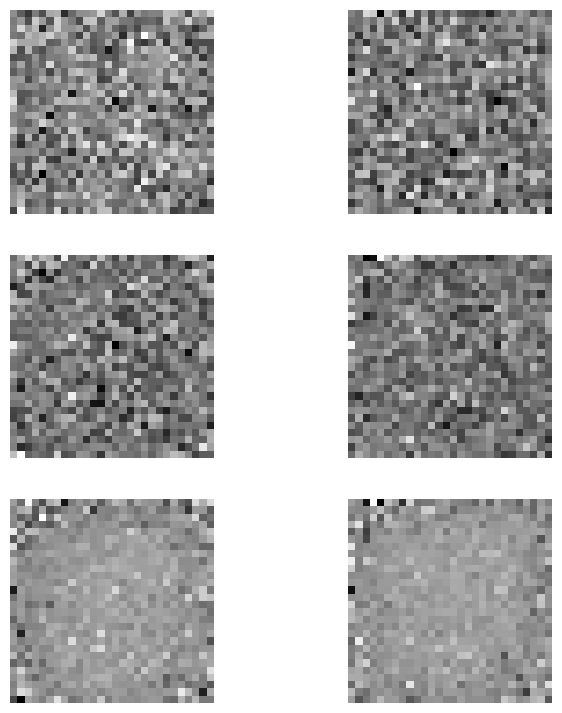

In [ ]:
plot_image_grid(backward_steps, title_prefix="backward")

generation from the base distribution

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

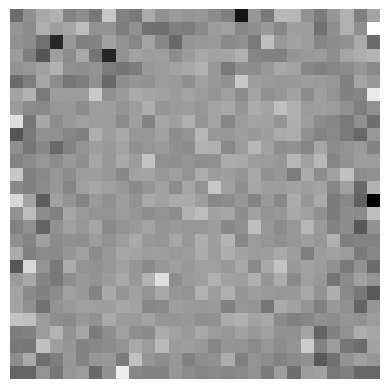

In [ ]:
z_sample = torch.randn(1, 784).to(device)
generated_x = model.backward(z_sample)
plt.imshow(generated_x.view(28, 28).cpu().detach(), cmap='gray')
plt.axis('off')